In [1]:
import numpy as np
import pandas as pd
from plotnine import *

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

from ex4_tools import *

from IPython.display import Markdown as md

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
===================================================
     Introduction to Machine Learning (67577)
===================================================

Skeleton for the AdaBoost classifier.

Author: Gad Zalcberg
Date: February, 2019

"""
import numpy as np


class AdaBoost(object):

    def __init__(self, WL, T):
        """
        Parameters
        ----------
        WL : the class of the base weak learner
        T : the number of base learners to learn
        """
        self.WL = WL
        self.T = T
        self.h = [None]*T     # list of base learners
        self.w = np.zeros(T)  # weights

    def train(self, X, y):
        """
        Parameters
        ----------
        X : samples, shape=(num_samples, num_features)
        y : labels, shape=(num_samples)
        Train this classifier over the sample (X,y)
        After finish the training return the weights of the
          samples in the last iteration.
        """
        # Initialize weights
        m = len(y)
        D = np.ones(m)/m

        for i in range(self.T):
          self.h[i] = self.WL(D, X, y)           #fit weak learner
          # calculate prediction
          y_hat = self.h[i].predict(X)
          # calcualte error rate
          err = D[(y_hat != y)].sum()
          # calculate current weights coefficients
          self.w[i] = np.log((1 - err) / err) / 2
          # update sample weights
          D = D * np.exp(-self.w[i] * y * y_hat)  

          # normalize D
          D /= D.sum()
        
        return D
        
              
    def predict(self, X, max_t):
        """
        Parameters
        ----------
        X : samples, shape=(num_samples, num_features)
        :param max_t: integer < self.T: the number of classifiers to use for the classification
        :return: y_hat : a prediction vector for X. shape=(num_samples)
        Predict only with max_t weak learners,
        """
        # initialize predictions vector        
        prediction = np.zeros(shape = (len(X))) 

        # join all hypothesis 
        for i in range(max_t):
              prediction += self.w[i] * self.h[i].predict(X)

        # calculate sign
        y_hat = np.sign(prediction)

        return y_hat

    def error(self, X, y, max_t):
        """
        Parameters
        ----------
        X : samples, shape=(num_samples, num_features)
        y : labels, shape=(num_samples)
        :param max_t: integer < self.T: the number of classifiers to use for the classification
        :return: error : the ratio of the correct predictions when predict only with max_t weak learners (float)
        """
        # predict H_maxt
        y_hat = self.predict(X, max_t)
        # compute error
        error = (y != y_hat).mean()
        return error



In [3]:
np.random.seed(100)
X,y = generate_data(5000,0)
X_test, y_test = generate_data(200,0)

In [4]:
T=500
adaboost = AdaBoost(DecisionStump, T = T)
adaboost.train(X,y);

In [5]:
train_errs = [adaboost.error(X,y, t) for t in range(T)]
test_errs = [adaboost.error(X_test, y_test, t) for t in range(T)]

## Un-Noised Data

### 10. Boosting Un-Noised Data
We generated 5000 random points without noise as our training data, and we will want to test our adaboost class after various iterations.
After boosting our weak-learner, that was trained on the train set we generated, we will test each "boosted" hypothesis from our hypothesis set (each $H_t$).

Here is a plot of the training error and the test error as a function of $T$:

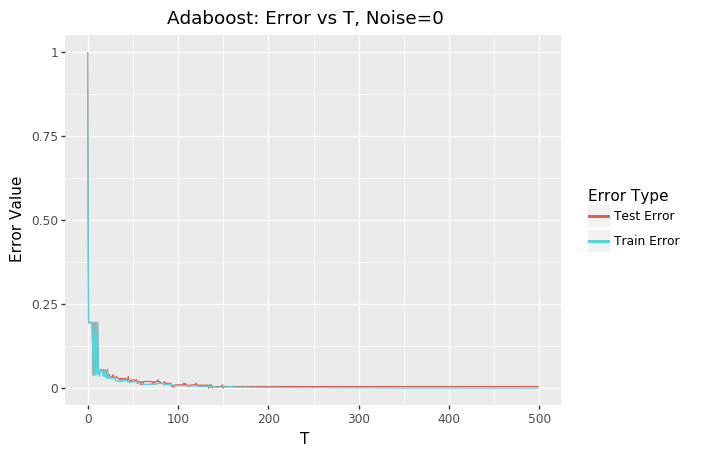

In [6]:
df = pd.DataFrame({"t":range(T),"train_err":train_errs,"test_err":test_errs})
df = df.melt(id_vars=['t'])

(ggplot(df) + geom_line(aes(x='t',y='value',color='variable')) +
 labs(title="Adaboost: Error vs T, Noise=0", x="T", y='Error Value') +
 scale_color_discrete(name="Error Type", labels=["Test Error","Train Error"])).draw();
                       

<br>
We can see that in the un-noised case, both of the error types gets lower as T grows, and both of them are nearly 0 for high T values

This is a very good output, because it means that our model is not suffering from "overfitting" (since both error types are low), and that we decreases our bias while keeping low variance.

In [7]:
def plot_classifier(t):
  adaboost_classifier = AdaBoost(DecisionStump, T = t)
  adaboost_classifier.train(X,y)
  decision_boundaries(adaboost_classifier, X_test, y_test, num_classifiers=t)

### 11. Plot Decision Boundaries
After comparing the different types of errors, we want to compare different sizes of boosted hypothesis.
<br>We plot the e decisions of the learned classifiers with $T \in \{5, 10, 50, 100, 200, 500\}$ together with the test data.

In [8]:
Ts = [5,10,50,100,200,500]

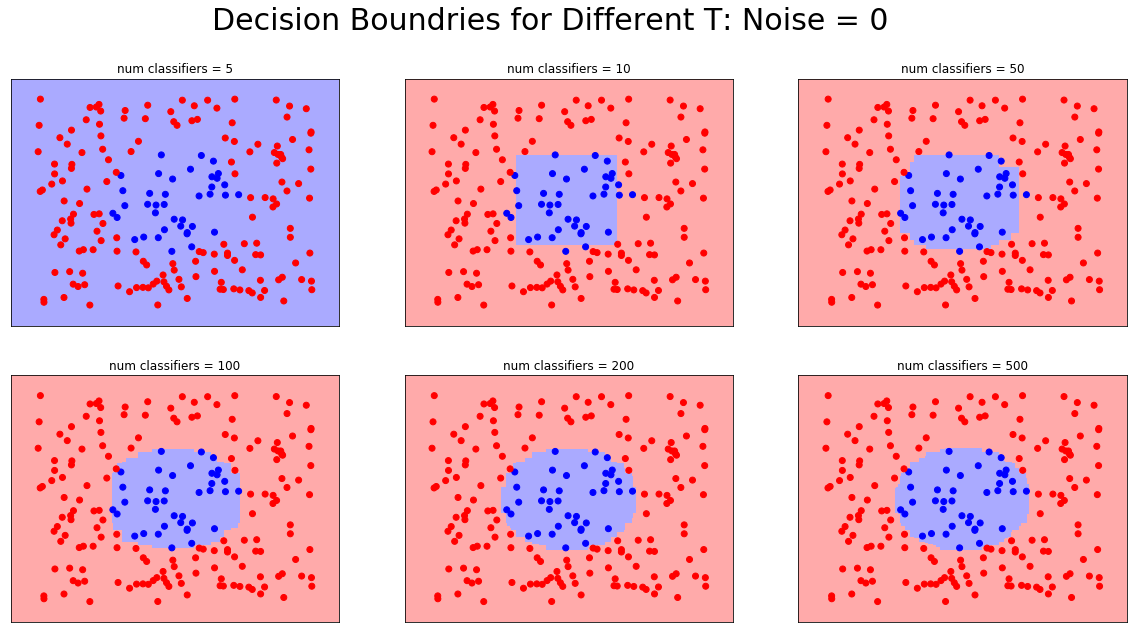

In [9]:
#11
fig = plt.figure(figsize=(20,10))
for i in range(len(Ts)):

  fig.add_subplot(231+i)  
  plot_classifier(Ts[i])
    
  
plt.suptitle("Decision Boundries for Different T: Noise = 0", fontsize=30)
plt.show()


We can see that as T grows, the decision boundries get "rounder" and more accurate. <br> Actually, since we have hypothesis familly of linear boundries, we join more and more squares from the different $H_t$ and get an illusion of a circle boundry.
<br> This is beautiful, since the original data was labeld with $f(x)$ is a function testinig wether the point is in a circle or not, as seen on `ex4_tools.py`


### 12. Finding the $\hat{T}$ that minimize the test error

We will find the T value that minimize the test error, and plot it  with the training data.

**Note:** Since we have few T that gets the same test error, we will return the first one, arbitrarily.

In [10]:
#12 
adaboost_classifier = AdaBoost(DecisionStump, T = T)
Dt = adaboost_classifier.train(X,y)
test_err = np.ones(T)
for t in range(T):
    test_err[t] = adaboost_classifier.error(X_test, y_test, max_t = t)

argmin = np.argmin(test_err)

print("T = {}, TestError = {}".format(argmin, test_err[argmin]))

T = 134, TestError = 0.0


We can see that when T = 134, we get a 0.0 Test Error for the first time. 
<br>Here is a plot of the training set, with the decision boundries for T = 134:

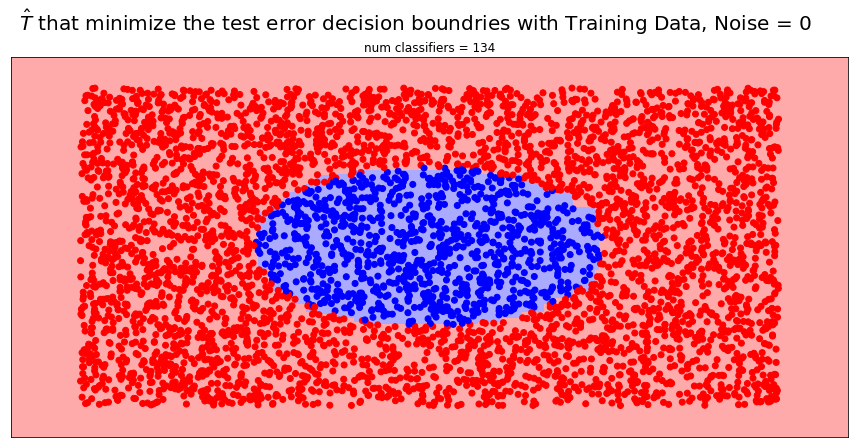

In [11]:
plt.figure(figsize=(15,7))
decision_boundaries(adaboost_classifier, X, y, argmin)
plt.suptitle("$\hat{T}$ that minimize the test error decision boundries with Training Data, Noise = 0", fontsize=20);

We can see that we have a bit classification mistakes on T = 134, but the test error was 0. I guess the reason is the test set size is way smaller, and if we were generate the data with a different seed it could be slightly different.

### 13. Last Iteration Weights:

Now, we will plot the desicion boundries for T=500, and give size by the last iteration of training weights ($D^T$):

Text(0.5, 0.98, 'Decision Boundries with weighted points, T = 500, noise=0')

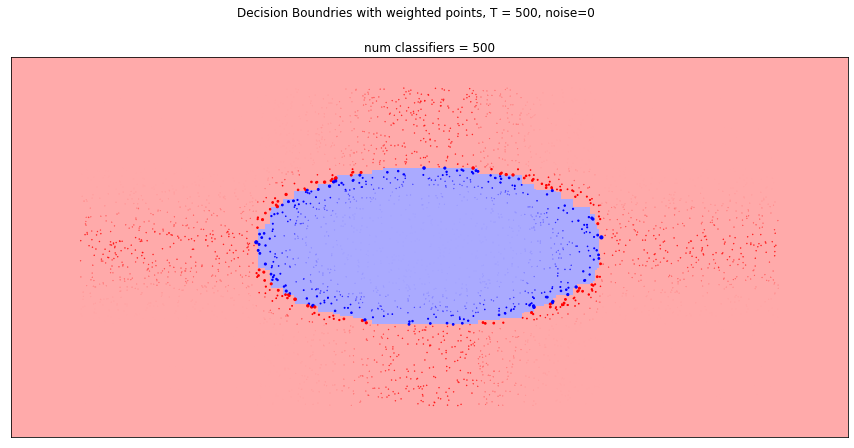

In [12]:
plt.figure(figsize=(15,7))
decision_boundaries(adaboost_classifier, X, y, T, weights = (Dt / np.max(Dt) * 10))
plt.suptitle("Decision Boundries with weighted points, T = 500, noise=0")

As we could expect, the data points that are closer to the decision boundries are bigger then those that are in the "surely classified" zone (The area far from the boundries).
<br>The points that are deep inside the boundries, or the ones way outside of it, kept getting lower and lower weights (since each cumulative hypothesis was labeled them correctly) and those that were closed to the boundry kept changing, since the area that close to the boundries were keep changing between -1 and 1.

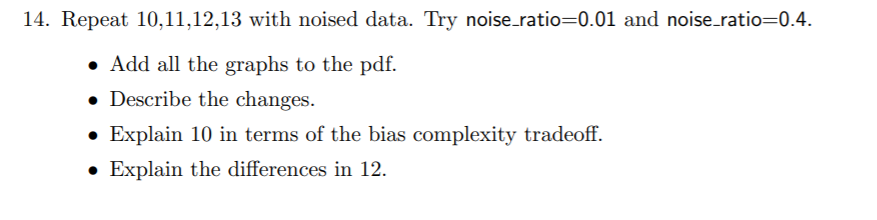

## Noised Data

### Noise = 0.01

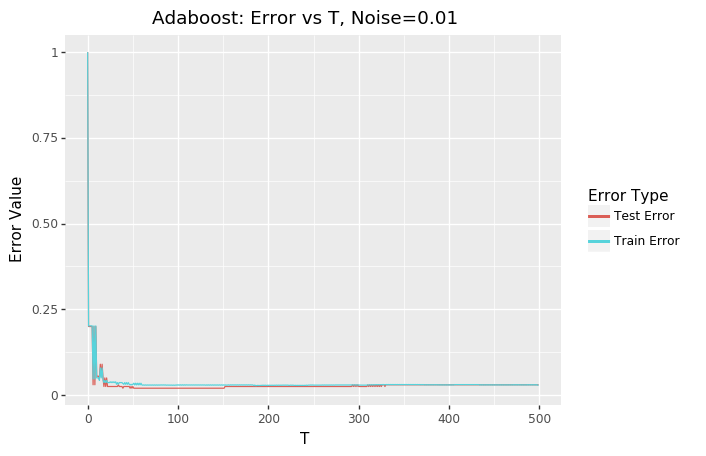

In [13]:
np.random.seed(100)
noise = 0.01
X,y = generate_data(5000,noise)
X_test, y_test = generate_data(200,noise)

T=500
adaboost = AdaBoost(DecisionStump, T = T)
adaboost.train(X,y)

train_errs = [adaboost.error(X,y, t) for t in range(T)]
test_errs = [adaboost.error(X_test, y_test, t) for t in range(T)]

df = pd.DataFrame({"t":range(T),"train_err":train_errs,"test_err":test_errs})
df = df.melt(id_vars=['t'])
(ggplot(df) + geom_line(aes(x='t',y='value',color='variable'))+
 labs(title="Adaboost: Error vs T, Noise={}".format(noise), x="T", y='Error Value') +
 scale_color_discrete(name="Error Type", labels=["Test Error","Train Error"])).draw();

It seems that while the Train Error stays almost constant, and the Test error decreases until T is around 200, and then increases again. Let's zoom in the graph to get a better look.

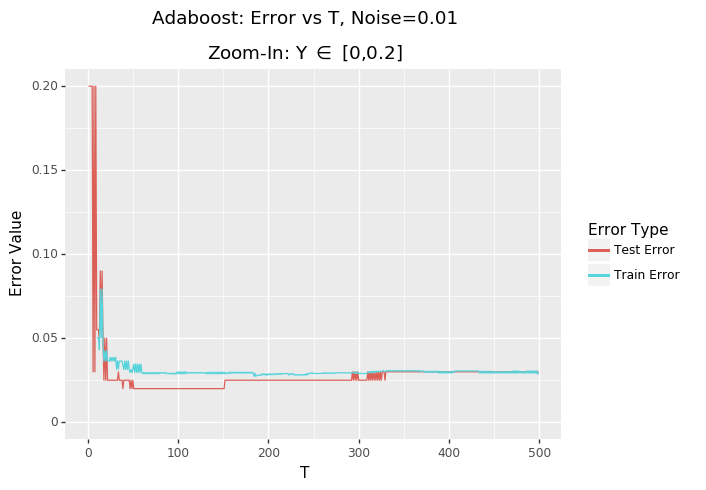

In [14]:
(ggplot(df) + geom_line(aes(x='t',y='value',color='variable'))+
 labs(title="Adaboost: Error vs T, Noise={}\n\nZoom-In: Y $\in$ [0,0.2]".format(noise), x="T", y='Error Value') +
 scale_color_discrete(name="Error Type", labels=["Test Error","Train Error"])+ylim(0,0.2)).draw();

We can see that both the train error and the test error are higher than the unnoised case.<br>
We can see that increasing T will reduce the bias dramatically, and up to a certain point preserving low variance, and that why MSE will decrease. But when we have very large T, the improvement in the bias becomes minor when comparing to the variance.


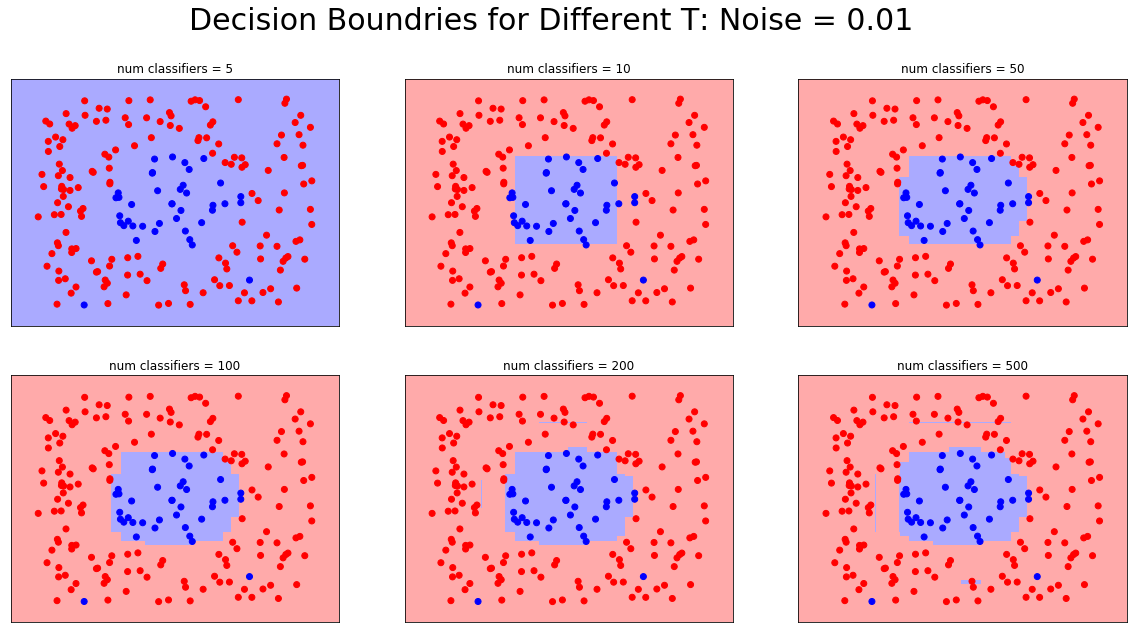

In [15]:
#11
fig = plt.figure(figsize=(20,10))
for i in range(len(Ts)):

  fig.add_subplot(231+i)  
  plot_classifier(Ts[i])
  
plt.suptitle("Decision Boundries for Different T: Noise = {}".format(noise), fontsize=30)

plt.show()

We can see that when we have noise, the boosting procedure is way less effective than the un-noised case, even for high values such as $T\geq200$, that were very good classifiers before adding noise.

According to the graph we have seen earlier, we can tell that up to a certain T we get a good approximation of the circle from which the data was tagged (before adding noise). When T is too high, we get a kind of "sheet" at the edges, which are classification errors that are probably due to noise. For a particular T we have low Bias on the Training set but high variance.

T = 39, TestError = 0.02


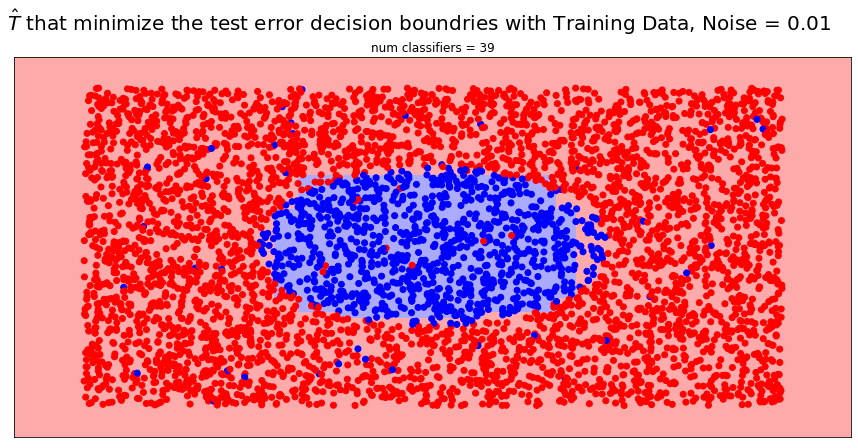

In [16]:
#12 
adaboost_classifier = AdaBoost(DecisionStump, T = T)
Dt = adaboost_classifier.train(X,y)
test_err = np.ones(T)
for t in range(T):
    test_err[t] = adaboost_classifier.error(X_test, y_test, max_t = t)

argmin = np.argmin(test_err)

print("T = {}, TestError = {}".format(argmin, test_err[argmin]) )


plt.figure(figsize=(15,7))
decision_boundaries(adaboost_classifier, X, y, argmin)
plt.suptitle("$\hat{{T}}$ that minimize the test error decision boundries with Training Data, Noise = {}".format(noise), fontsize=20);

We can see that for the data we sampled, the lowest Test Error is getting after 39 interations. We can see that altough we have noisy points that are way outside the decision boundries, in lower T, the bias is low and the variance is not high enough to "chase" all the blue points, wherever they are. we can see that we get only two boundries, the main circle, and another small rectangle on the right.

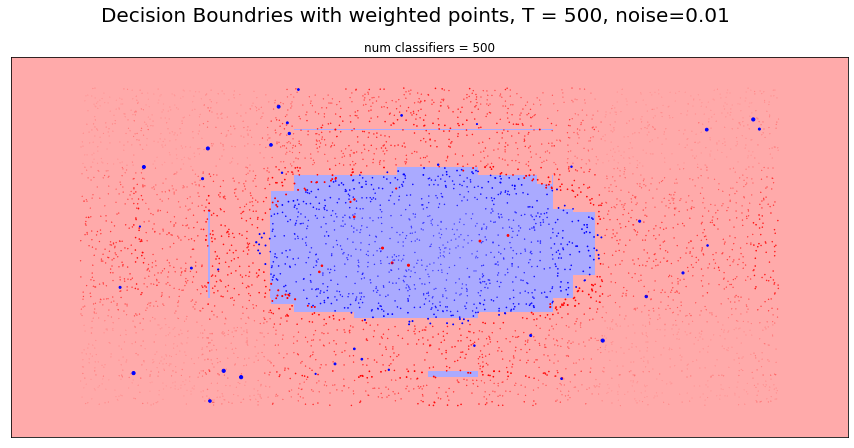

In [17]:
plt.figure(figsize=(15,7))
decision_boundaries(adaboost_classifier, X, y, T, weights = (Dt / np.max(Dt) * 10))
plt.suptitle("Decision Boundries with weighted points, T = 500, noise={}".format(noise), fontsize=20);

Here we can see that the biggest points (means the most weighted points) are the blue points (+1) that are not inside the decision boundry. We can understand that the next step will be create decision boundries for 1 around them as well, but in further interations. In that case, the variance will be larger on T=500.

### Noise = 0.4

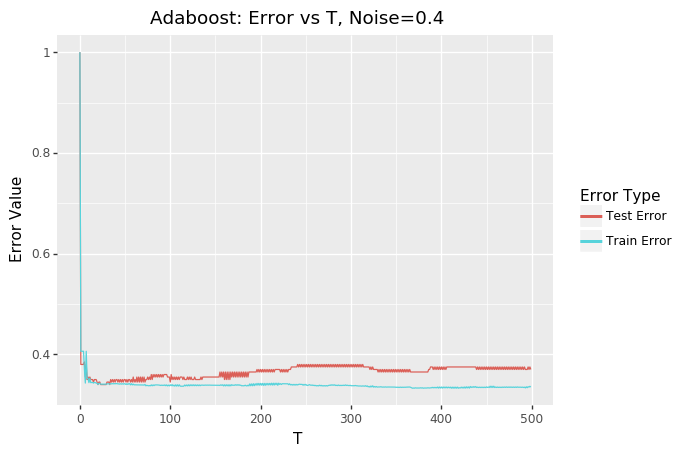

In [18]:
noise = 0.4
X,y = generate_data(5000,noise)
X_test, y_test = generate_data(200,noise)

T=500
adaboost = AdaBoost(DecisionStump, T = T)
adaboost.train(X,y)

train_errs = [adaboost.error(X,y, t) for t in range(T)]
test_errs = [adaboost.error(X_test, y_test, t) for t in range(T)]

df = pd.DataFrame({"t":range(T),"train_err":train_errs,"test_err":test_errs})
df = df.melt(id_vars=['t'])
(ggplot(df) + geom_line(aes(x='t',y='value',color='variable'))+
 labs(title="Adaboost: Error vs T, Noise={}".format(noise), x="T", y='Error Value') +
 scale_color_discrete(name="Error Type", labels=["Test Error","Train Error"])).draw();

Here we can see that on higher T values, the Test Error increases significantly. As we said before, the bias reduces, but the variance is getting higher and higher, and so is the estimation error.

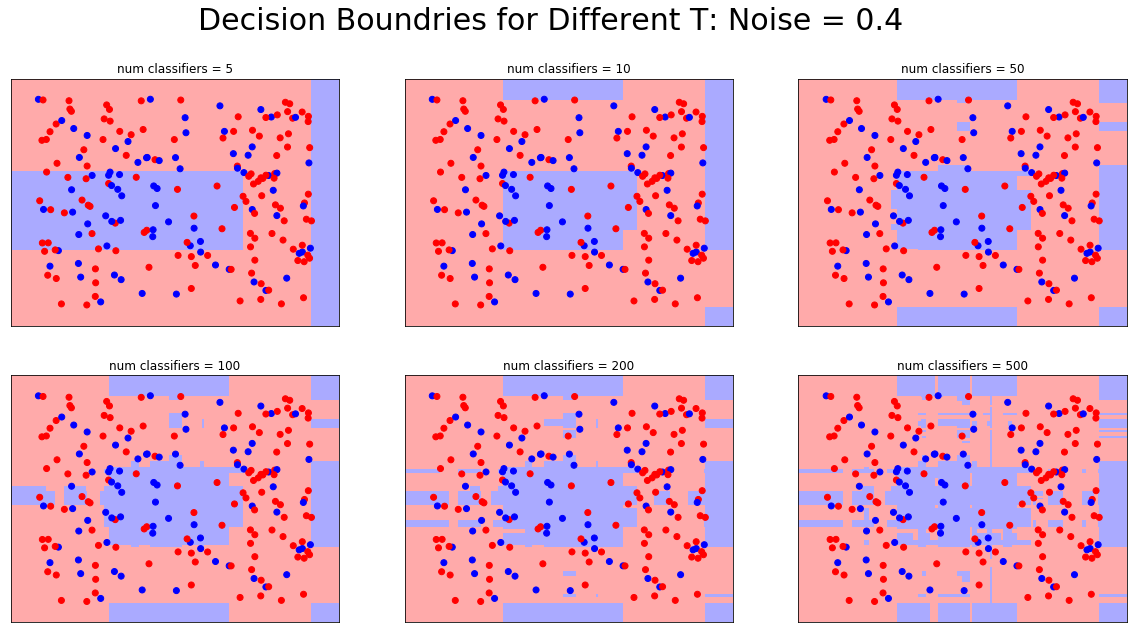

In [19]:

#11
fig = plt.figure(figsize=(20,10))
for i in range(len(Ts)):

  fig.add_subplot(231+i)  
  plot_classifier(Ts[i])
  
plt.suptitle("Decision Boundries for Different T: Noise = {}".format(noise), fontsize=30)
plt.show()

Now, we can see that accordingly to what we found before,  we get a very high variance while T grows.
Let us draw the T that minimize the test error with the training data.

T = 20, TestError = 0.34


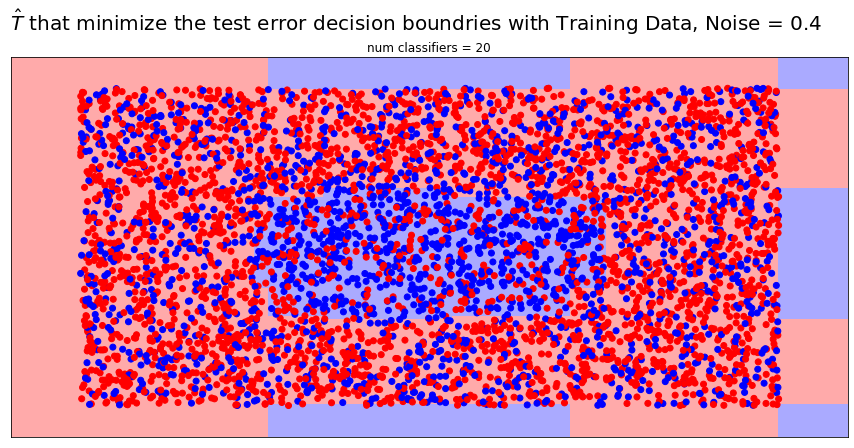

In [20]:

#12 
adaboost_classifier = AdaBoost(DecisionStump, T = T)
Dt = adaboost_classifier.train(X,y)
test_err = np.ones(T)
for t in range(T):
    test_err[t] = adaboost_classifier.error(X_test, y_test, max_t = t)

argmin = np.argmin(test_err)

print("T = {}, TestError = {}".format(argmin, test_err[argmin]) )


plt.figure(figsize=(15,7))
decision_boundaries(adaboost_classifier, X, y, argmin)
plt.suptitle("$\hat{{T}}$ that minimize the test error decision boundries with Training Data, Noise = {}".format(noise), fontsize=20);

First, it is amazing to see how noisy the data is. We can see that for the T we got, we still get nice decision boundries in the middle that can tell us where is the biggest mass of blue points on the Test Data. We can also see that we have boundroies near the edges, since the high noise make the decision rule very difficult. We can also see that due the high noise, we are getting higher approximation error, and therefor the best T selected will be a lower T that try to minimize the estimation error.

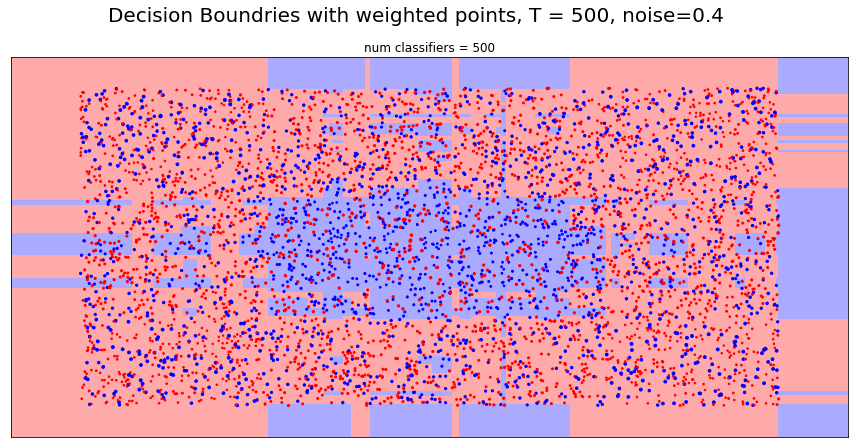

In [21]:
plt.figure(figsize=(15,7))
decision_boundaries(adaboost_classifier, X, y, T, weights = (Dt / np.max(Dt) * 10))
plt.suptitle("Decision Boundries with weighted points, T = 500, noise={}".format(noise), fontsize=20);